In [ ]:
import os
import glob
import re
import dotenv
import h5py
import fastmri
import torch
import numpy as np
import matplotlib.pyplot as plt
from fastmri.data.transforms import to_tensor, complex_center_crop
from ReconFormer_main.models.Recurrent_Transformer import ReconFormer

dotenv.load_dotenv()
TEST_PATH    = os.environ['SINGLECOIL_VAL_PATH']
OUT_FIG      = "comparison_vertical.png"
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ACCEL        = 8
CENTER_FRAC  = 0.04
TEST_FILE_INDEX = 0

# ─── 1) Load one test volume + GT (k-space to GPU) ─────────────────────────────
def load_kspace_and_gt(path, W=320, H=320):
    with h5py.File(path, 'r') as hf:
        arr = hf['kspace'][()]
        gt  = hf['reconstruction_rss'][()]
    k = complex_center_crop(to_tensor(arr), (W, H)).to(DEVICE)  # move k-space to GPU
    return k, gt  # GT remains on CPU for plotting

test_files = sorted(glob.glob(os.path.join(TEST_PATH, "*.h5")))
kvol, gt_vol = load_kspace_and_gt(test_files[TEST_FILE_INDEX])
slice_idx     = kvol.shape[0] // 2
H, W          = kvol.shape[1], kvol.shape[2]

# 1) Create zero mask

In [11]:
# ─── 2) Create mask ────────────────────────────────────────────────────────
mask = torch.zeros(1, 1, H, W, dtype=torch.bool, device=DEVICE)
num_low = int(round(H * CENTER_FRAC))
start   = (H - num_low) // 2
end     = start + num_low
mask[:, :, start:end, :] = True
for row in range(H):
    if row < start or row >= end:
        if row % ACCEL == 0:
            mask[:, :, row, :] = True

# ─── 3) Zero‐filled baseline on GPU ─────────────────────────────────────────────
def zero_filled(kri, mask):
    """
    kri: [S,H,W,2] on GPU
    mask: [1,1,H,W] boolean on GPU
    returns mag-vol [S,H,W] on GPU
    """
    k_ch      = kri.permute(0,3,1,2)                 # [S,2,H,W]
    m         = mask.expand(k_ch.shape[0], 2, H, W)  # [S,2,H,W]
    k_und     = k_ch * m                             # [S,2,H,W]
    k_und_cl  = k_und.permute(0,2,3,1)               # [S,H,W,2]
    img       = fastmri.ifft2c(k_und_cl)             # [S,H,W,2]
    mag       = fastmri.complex_abs(img)            # [S,H,W]
    return mag

zf_vol = zero_filled(kvol, mask)
zf_img = zf_vol[slice_idx]  # [H,W] on GPU

# 2) Load and Run ReconFormer 

In [13]:
# def infer_arch(sd):
#     num_ch, depths = [], []
#     for b in (1,2,3):
#         w = sd[f"block{b}.encoder.0.weight"]
#         num_ch.append(w.shape[0])
#         pat = re.compile(rf"block{b}\.RFB\.RPTL1\.residual_group\.blocks\.(\d+)\.")
#         layers = {int(m.group(1)) for name in sd if (m:=pat.search(name))}
#         depths.append(len(layers))
#     return tuple(num_ch), tuple(depths)

def load_model_from_ckpt(ckpt_path):
    # print(f"Loading model from {ckpt_path}")
    if ckpt_path.endswith('F_X8_checkpoint.pth'):
        pass
        # # ! this handles local save of X8 checkpoint
        # sd = torch.load(ckpt_path, map_location="cpu")
        # num_ch, depths = infer_arch(sd)
        # model = ReconFormer(
        #     in_channels=2, out_channels=2,
        #     num_ch=num_ch, down_scales=(2,1,1.5),
        #     num_iter=5, img_size=320,
        #     num_heads=(6,6,6), depths=depths,
        #     window_sizes=(8,8,8),
        #     resi_connection="1conv",
        #     mlp_ratio=2.0,
        #     use_checkpoint=(False,)*6
        # ).to(DEVICE)
        # model.load_state_dict(sd, strict=True)
        # model.eval()
    else:
        # ! this handles load from wandb
        checkpoint = torch.load(ckpt_path)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = ReconFormer(
            in_channels=2, out_channels=2,
            num_ch=(96,48,24), down_scales=(2,1,1.5),
            num_iter=1, img_size=320,
            num_heads=(6,6,6), depths=(6,6,6),
            window_sizes=(8,8,8),
            resi_connection="1conv", mlp_ratio=2.0,
            use_checkpoint=(False,)*6
        ).to(device)
        model.load_state_dict(checkpoint['model_state_dict'])

        # Set the model to evaluation mode
        model.eval()

    return model

def run_reconformer(model, slice_ri):
    mag = fastmri.complex_abs(slice_ri)
    kn  = slice_ri / (mag[..., None] + 1e-12)
    k0  = kn.permute(2,0,1).unsqueeze(0).to(DEVICE)
    mask= torch.ones(1,1,kn.shape[0],kn.shape[1], dtype=torch.bool, device=DEVICE)
    img_zf = fastmri.ifft2c(kn)
    x = img_zf.permute(2,0,1).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out = model(x, k0, mask)
    out_ri = out.squeeze(0).permute(1,2,0).cpu()
    return fastmri.complex_abs(out_ri)

# 3) Optionally Download new Model from Wandb

In [ ]:
import wandb
api = wandb.Api()

model_id = 'rgqmpp00'


run = api.run(f"sasha-aos-georgia-institute-of-technology/cs7643-fastmri/{model_id}")
artifact = run.file("checkpoints/best_model.pt")\
             .download(root=f"./checkpoints_wandb/{model_id}", replace=True)
state    = torch.load(artifact.name, map_location="cpu")["model_state_dict"]

# 4) Plot graphs

/home/jschopme/miniconda3/envs/cs7643-reconformer/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1744233415586/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


✅ Saved vertical comparison → comparison_vertical.png


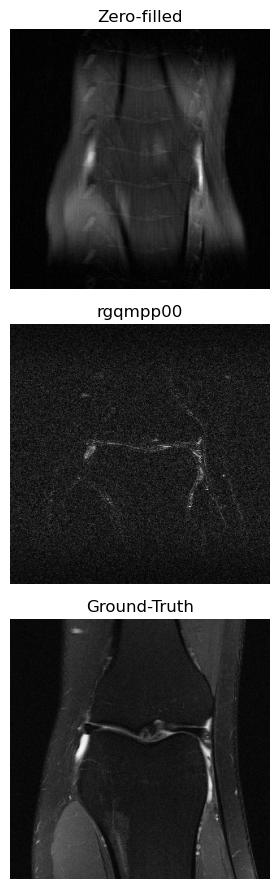

In [ ]:

# specify list of models with their id to be labeled in plots
models = [
    # ("ReconFormer F_X8", '/home/jschopme/dl/cs7643-fastmri/ReconFormer_main/checkpoints/checkpoints/F_X8_checkpoint.pth'),
    ("rgqmpp00", f'/home/jschopme/dl/cs7643-fastmri/checkpoints_wandb/checkpoints/{model_id}/best_model.pt'),
]


recon_images = [zf_img]
titles       = ["Zero-filled"]

for title, ckpt in models:
    model       = load_model_from_ckpt(ckpt)
    slice_ri = kvol[slice_idx]  # [H,W,2] on GPU
    # recon    = run_reconformer(m, slice_ri, mask)
    recon    = run_reconformer(model, slice_ri)
    recon_images.append(recon)
    titles.append(title)

gt_img = gt_vol[slice_idx]  # [H,W] on CPU

# ─── 5) Plot vertically ────────────────────────────────────────────────────────
n = len(recon_images) + 1
fig, axs = plt.subplots(n, 1, figsize=(4, 3*n))

for i, ax in enumerate(axs):
    if i < len(recon_images):
        img = recon_images[i].cpu().numpy()
        title = titles[i]
    else:
        img = gt_img
        title = "Ground-Truth"
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(title, fontsize=12)

plt.tight_layout()
plt.savefig(OUT_FIG, dpi=150)
print(f"✅ Saved vertical comparison → {OUT_FIG}")
